In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np

import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.set()

In [2]:
class SocialDynamics:
    """
    A simulation of social dynamics in a network - strengthening opinions and weights based on
    random interactions between nodes.
    
    """

    def __init__(self, network_size=50, alpha=0.05, beta=0.3, gamma=4):

        '''
        
        '''

        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):

        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5

        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)
        self.step = 0


    def observe(self):

        self.layout = nx.spring_layout(self.graph, pos=self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color= [self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color = [self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap = plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha = 0.7, vmin=0, vmax=1
        )
        plt.title("Step: " + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:

            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)

        else:

            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]

            for i in range(0, 1):
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1 - i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight + self.beta * weight * (1-weight) * (1-self.gamma * abs(opinions[0] - opinions[1])))

            if self.graph.edges[edge]['weight'] < 0.5:
                self.graph.remove_edge(*edge)

        self.step += 1


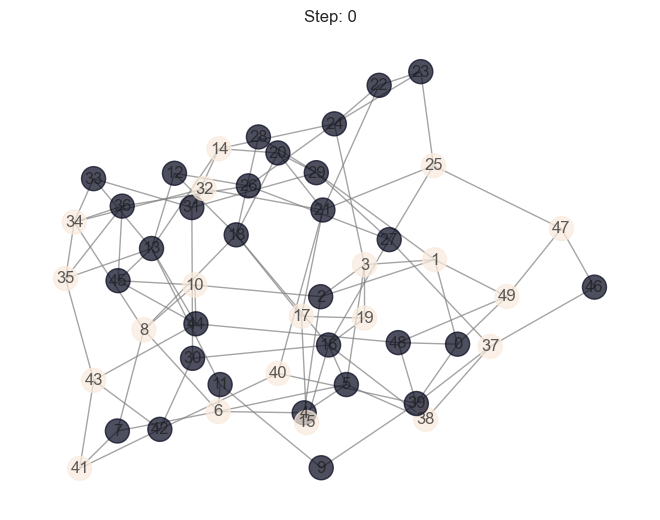

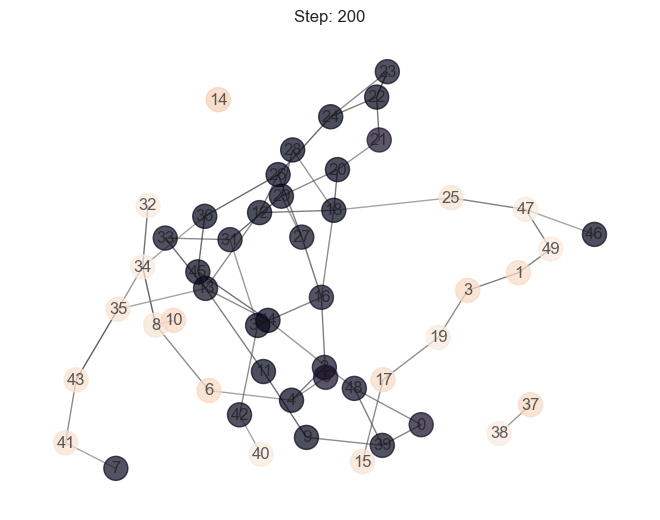

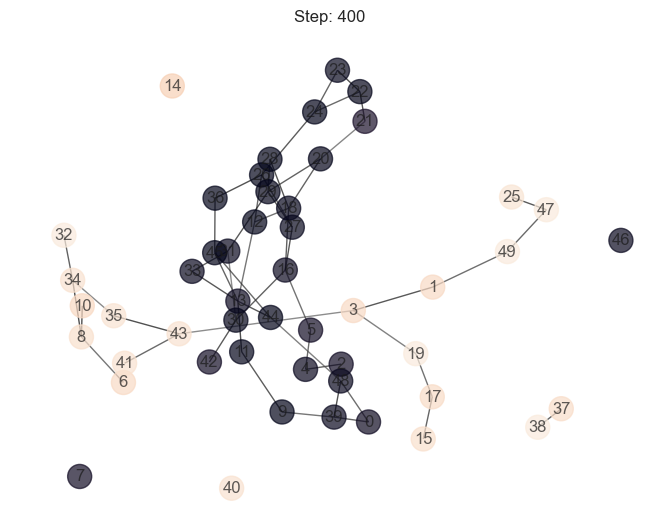

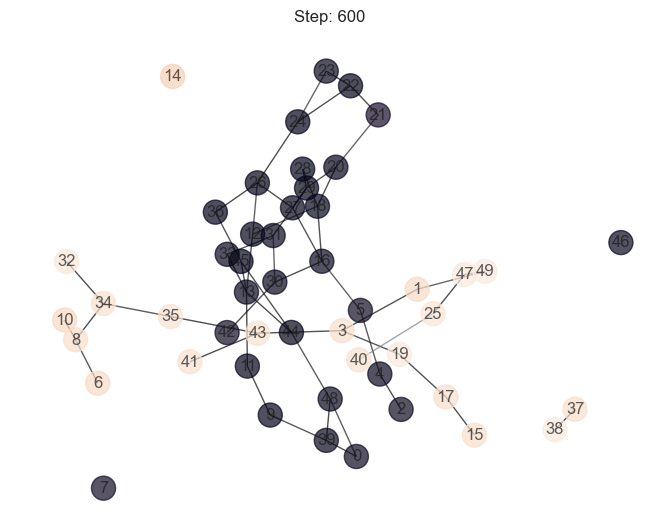

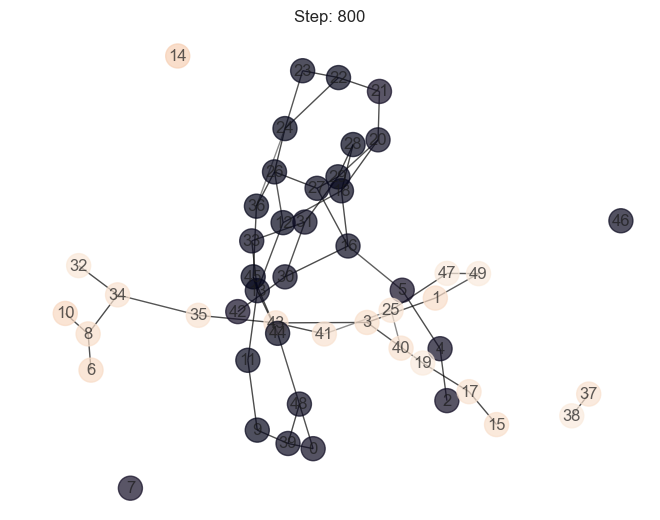

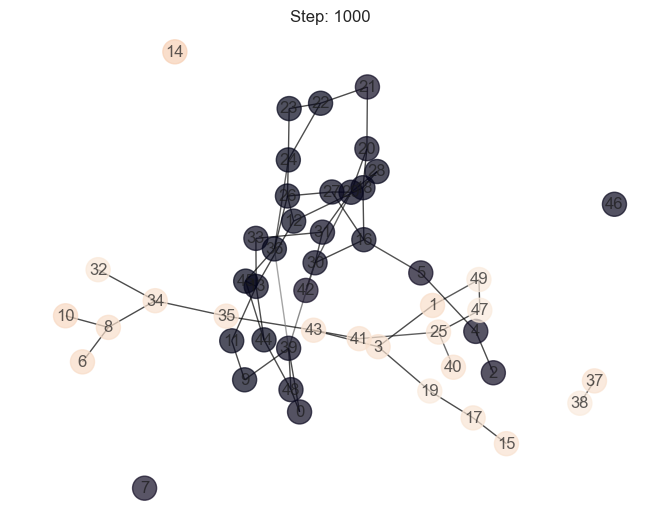

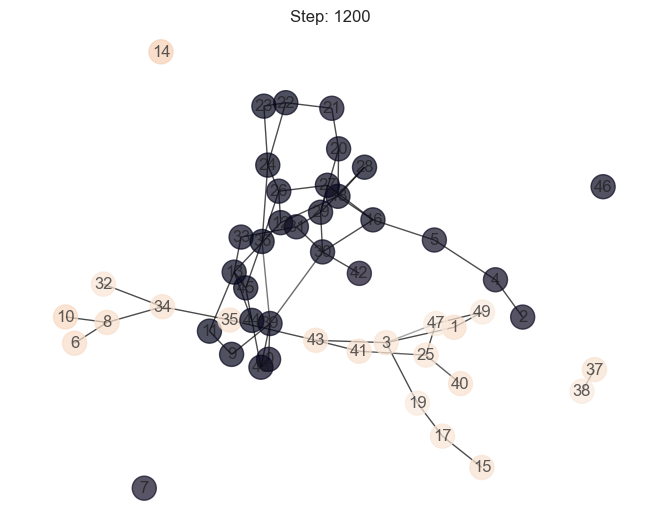

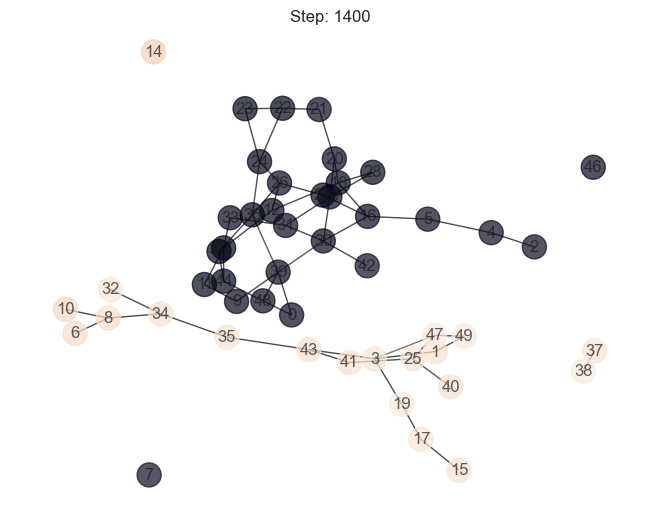

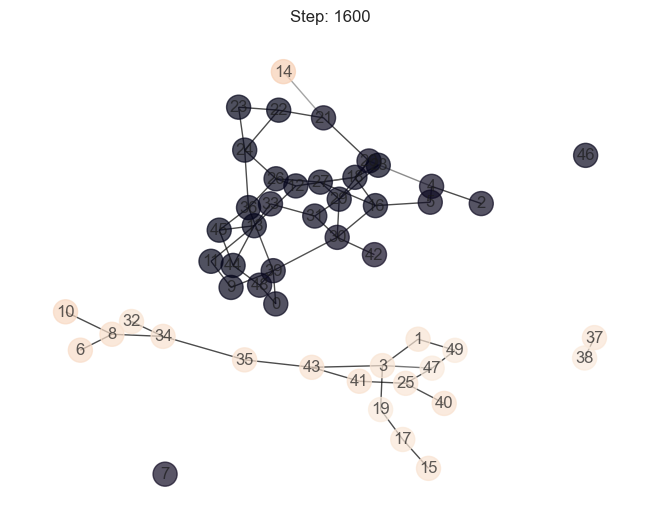

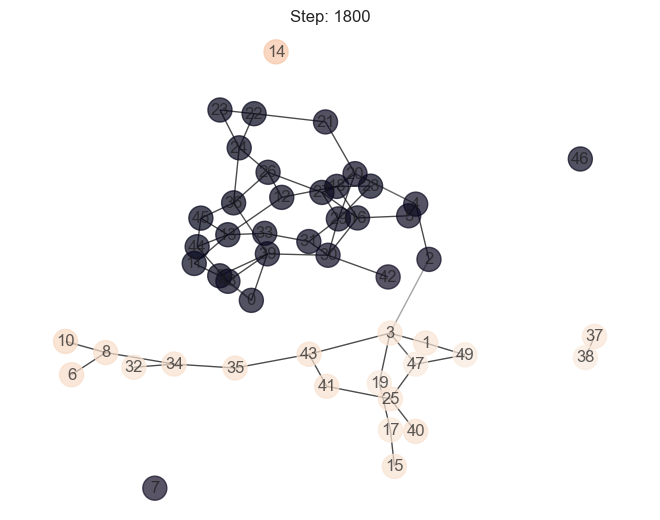

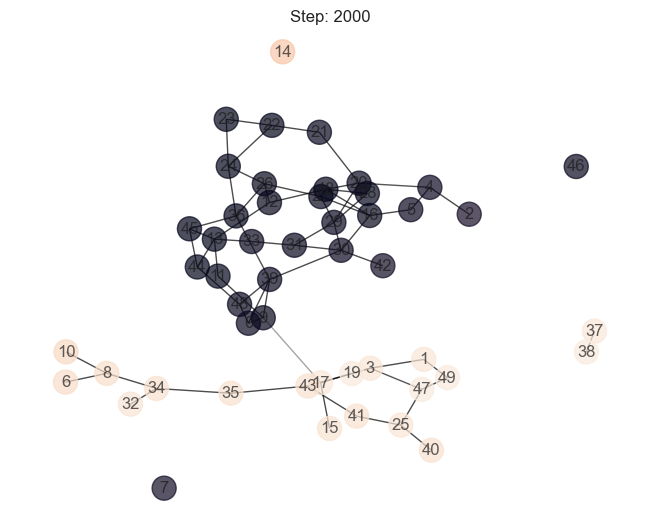

In [3]:
sim = SocialDynamics()
sim.initialize()
plt.figure()
sim.observe()

for i in range(10):
    for i in range(200):
        sim.update()
    plt.figure()
    sim.observe()

In [4]:
class AntiEstablishment:

    def __init__(self, graph=nx.watts_strogatz_graph(n=100, k=5, p=0.5), gamma=0.5, waiting=(0.6, 0.4)):

        self.graph = graph
        self.gamma = gamma
        self.node_record = [self.graph.nodes]
        self.m_antiestablishment, self.m_conformist = [], []
        self.waiting_1, self.waiting_2 = waiting

    def initialize(self):

        for node in self.graph.nodes:
            self.graph.nodes[node]['establishment'] = True if random.random() < self.gamma else False
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['delay'] = np.rint(np.random.normal(self.waiting_1, self.waiting_2))

        self.layout = nx.spring_layout(self.graph)
        self.step = 0

    def observe(self):
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()

        size = [(self.graph.nodes[i]['delay'] + .25) * 30
                for i in self.graph.nodes]  # 0.25 is just to make the graph look nicer
        labels = {i: round(self.graph.nodes[i]["opinion"], 2)
                  for i in self.graph.nodes}    

        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            labels = labels, node_size = size,
            node_color = [self.graph.nodes[i]["antiestablishment"] for i in self.graph.nodes],
            edge_cmap = plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1
        )
        plt.title("Steps: "+ str(self.step))


    def update(self):
        selected_node = random.sample(list(self.graph.nodes), 1)[0]
        neighbors = [key for key in self.graph.neighbors(selected_node)]
        delay = int(self.graph.nodes[selected_node]["delay"][0])

        personal = self.node_record[-delay] if len(self.node_record) >= delay else self.node_record[-1]
        trait = np.mean([personal[i]["opinion"] for i in neighbors])

        if self.graph.nodes[selected_node]["antiestablishment"]:
            self.graph.nodes[selected_node]["opinion"] = np.random.binomial(1, 1 - trait)
        else:
            self.graph.nodes[selected_node]["opinion"] = np.random.binomial(1, trait)
        self.node_record.append(self.graph.nodes)

        p_antiestablishment = [self.graph.nodes[i]["opinion"] if self.graph.nodes[i]["antiestablishment"]
                               else None for i in self.graph.nodes]
        
        p_conformists = [self.graph.nodes[i]["opinion"]if not self.graph.nodes[i]["antiestablishment"]
                         else None for i in self.graph.nodes]
        
        self.m_antiestablishment.append(np.mean(list(filter(None.__ne__, p_antiestablishment))))
        self.m_conformist.append(np.mean(list(filter(None.__ne__, p_conformists))))

        self.step +=1

    def plot_figure(self):
        plt.figure()
        plt.plot(range(len(self.m_antiestablishment)), self.m_antiestablishment, "g-", label="antiestablishment")
        plt.plot(range(len(self.m_conformist)), self.m_conformist, "r-", label="conformist")
        plt.legend()

In [5]:
t = AntiEstablishment(gamma=0.2, waiting=(0.6, 1))
t.initialize()

plt.figure()
t.observe()

for i in range(10):
    for i in range(20):
        t.update()
t.plot_figure()
plt.xlabel("Steps")
plt.ylim(0,1.1)
plt.title("Watts-Strogatz, p=0.2")
plt.ylabel("Average Opinion")

KeyError: 'antiestablishment'

<Figure size 640x480 with 0 Axes>